In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import sys
import time
import logging  # [LOGGING] Importar la librería de logging
import random  # [SEED] Importar la librería random de Python
import numpy as np  # [SEED] Importar NumPy
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm # Para barra de progreso
from prettytable import PrettyTable # Para tabla de parámetros (pip install prettytable)

# Importar tu modelo corregido (asegúrate de que el archivo .py esté en la carpeta)
sys.path.append("KAN_models")
from SBTAYLOR_KAN import Net as KAN_Model 

# Configuración de Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Semilla
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

Usando dispositivo: cuda


In [2]:
IMAGENET_PATH = "./data"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

RUN_SAVE_DIR = os.path.join("models/sbtaylor_kan_cotton", f"run_{timestamp}")
os.makedirs(RUN_SAVE_DIR, exist_ok=True)

MODEL_NAME = "sbtaylor_kan.best_weights.pth"
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, MODEL_NAME)

In [3]:
LOG_FILE_PATH = os.path.join(RUN_SAVE_DIR, "training_run.log")

In [4]:
# --- [LOGGING] CONFIGURACIÓN DEL LOGGER ---
# Configura el logger para que escriba en un archivo y en la consola.
logging.basicConfig(
    level=logging.INFO,  # Nivel mínimo de mensajes a registrar (INFO, WARNING, ERROR)
    format="%(asctime)s - %(levelname)s - %(message)s",  # Formato del mensaje
    handlers=[
        logging.FileHandler(
            LOG_FILE_PATH, mode="w"
        ),  # Escribe en el archivo .log (modo 'w' para sobreescribir en cada ejecución)
        logging.StreamHandler(),  # Muestra los logs en la consola
    ],
)

# Ahora, en lugar de print(), usaremos logging.info()
logger = logging.getLogger()

logger.info("Modelo SBTAYLOR_KAN.Net importado correctamente.")
logger.info(f"Los pesos del modelo se guardarán en: '{MODEL_SAVE_PATH}'")
logger.info(f"El registro de entrenamiento se guardará en: '{LOG_FILE_PATH}'")

2025-12-05 20:48:57,694 - INFO - Modelo SBTAYLOR_KAN.Net importado correctamente.
2025-12-05 20:48:57,696 - INFO - Los pesos del modelo se guardarán en: 'models/sbtaylor_kan_cotton\run_20251205_204857\sbtaylor_kan.best_weights.pth'
2025-12-05 20:48:57,698 - INFO - El registro de entrenamiento se guardará en: 'models/sbtaylor_kan_cotton\run_20251205_204857\training_run.log'


In [5]:
logger.info(f"Versión de PyTorch: {torch.__version__}")
logger.info(f"¿CUDA está disponible?: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    logger.info(
        f"Versión de CUDA con la que PyTorch fue compilado: {torch.version.cuda}"
    )
    logger.info(f"Número de GPUs disponibles: {torch.cuda.device_count()}")
    logger.info(f"Nombre de la GPU actual: {torch.cuda.get_device_name(0)}")
else:
    logger.info(
        "PyTorch no puede encontrar CUDA. Es probable que hayas instalado la versión de solo CPU."
    )

2025-12-05 20:48:57,740 - INFO - Versión de PyTorch: 2.9.0+cu126
2025-12-05 20:48:57,742 - INFO - ¿CUDA está disponible?: True
2025-12-05 20:48:57,744 - INFO - Versión de CUDA con la que PyTorch fue compilado: 12.6
2025-12-05 20:48:57,747 - INFO - Número de GPUs disponibles: 1
2025-12-05 20:48:57,757 - INFO - Nombre de la GPU actual: NVIDIA GeForce RTX 4090


In [6]:
# --- 2. PARÁMETROS DE ENTRENAMIENTO ---
set_seed(42)  # [SEED] Establecer la semilla para reproducibilidad
BATCH_SIZE = 64
NUM_EPOCHS = 150
LEARNING_RATE = 1e-4
NUM_CLASSES = 4
NUM_WORKERS = 4

# print hyperparameters
logging.info(f"--- Hyperparámetros de Entrenamiento ---")
logging.info(f"Batch Size: {BATCH_SIZE}")
logging.info(f"Num Epochs: {NUM_EPOCHS}")
logging.info(f"Learning Rate: {LEARNING_RATE}")
logging.info(f"Num Classes: {NUM_CLASSES}")
logging.info(f"Num Workers: {NUM_WORKERS}")

2025-12-05 20:48:57,787 - INFO - --- Hyperparámetros de Entrenamiento ---


2025-12-05 20:48:57,788 - INFO - Batch Size: 64
2025-12-05 20:48:57,789 - INFO - Num Epochs: 150
2025-12-05 20:48:57,791 - INFO - Learning Rate: 0.0001
2025-12-05 20:48:57,794 - INFO - Num Classes: 4
2025-12-05 20:48:57,796 - INFO - Num Workers: 4


In [7]:
# --- 3. PREPARACIÓN DEL DATASET IMAGENET ---
# (El código interno no cambia, solo los prints)
transform_train = transforms.Compose(
    [
        transforms.Resize((224, 224)), # Tamaño estándar
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30), # Rotar hojas
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)
transform_val = transforms.Compose(
    [
        transforms.Resize(256), # Redimensionar para validación
        transforms.CenterCrop(224), # Recorte central
        transforms.ToTensor(), # Convertir a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalización
    ]
)

logger.info(f"\nCargando dataset de {IMAGENET_PATH}...")
if not os.path.isdir(IMAGENET_PATH):
    logger.error(f"Error: La ruta de ('{IMAGENET_PATH}') no es válida.")
    sys.exit(1)

train_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGENET_PATH, "train"), transform=transform_train
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(IMAGENET_PATH, "valid"), transform=transform_val
)


dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
class_names = train_dataset.classes
logger.info(f"Clases detectadas: {class_names}")

2025-12-05 20:48:57,841 - INFO - 
Cargando dataset de ./data...
2025-12-05 20:48:57,907 - INFO - Clases detectadas: ['Fresh_Leaf', 'Leaf_Reddening', 'Leaf_Spot_Bacterial_Blight', 'Yellowish_Leaf']


In [8]:
# --- 4. INICIALIZACIÓN DEL MODELO, CRITERIO Y OPTIMIZADOR ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"\nUsando dispositivo: {device}")

2025-12-05 20:48:57,941 - INFO - 
Usando dispositivo: cuda


+-----------------+--------------------+---------------------+
|      Modelo     | Parámetros Totales | Ratio de Compresión |
+-----------------+--------------------+---------------------+
| VGG16 (Clásico) |    134,276,932     |     1.0x (Base)     |
|   SBTAYLOR-KAN  |     54,129,720     |   2.5x más pequeño  |
+-----------------+--------------------+---------------------+


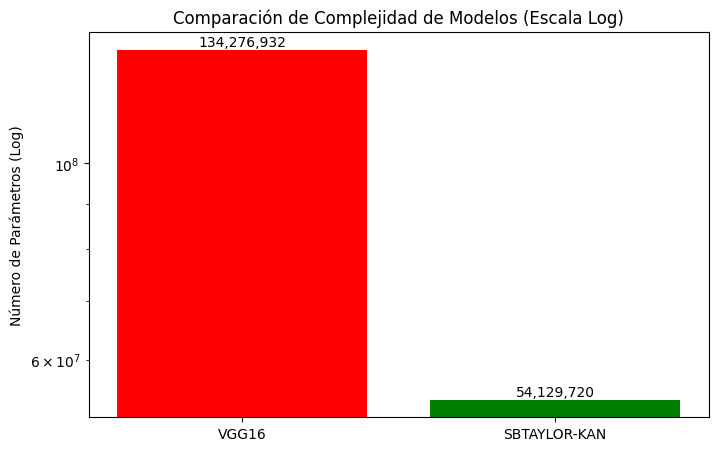

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def compare_models_complexity(num_classes):
    # 1. Instanciar VGG16 (Clásica)
    vgg16 = models.vgg16(weights=None) # Sin pesos, solo para ver estructura
    vgg16.classifier[6] = nn.Linear(4096, num_classes) # Ajustar salida
    
    # 2. Instanciar tu KAN (SBTAYLOR)
    kan_model = KAN_Model(num_classes=num_classes)
    
    # 3. Contar
    vgg_params = count_parameters(vgg16)
    kan_params = count_parameters(kan_model)
    
    # 4. Tabla de Resultados
    table = PrettyTable()
    table.field_names = ["Modelo", "Parámetros Totales", "Ratio de Compresión"]
    table.add_row(["VGG16 (Clásico)", f"{vgg_params:,}", "1.0x (Base)"])
    table.add_row(["SBTAYLOR-KAN", f"{kan_params:,}", f"{vgg_params/kan_params:.1f}x más pequeño"])
    
    print(table)
    
    # Visualización Gráfica (Logarítmica porque la diferencia es enorme)
    plt.figure(figsize=(8, 5))
    plt.bar(['VGG16', 'SBTAYLOR-KAN'], [vgg_params, kan_params], color=['red', 'green'])
    plt.yscale('log') # Importante: Escala logarítmica
    plt.title('Comparación de Complejidad de Modelos (Escala Log)')
    plt.ylabel('Número de Parámetros (Log)')
    for i, v in enumerate([vgg_params, kan_params]):
        plt.text(i, v, f"{v:,}", ha='center', va='bottom')
    plt.show()

    return vgg16, kan_model

# Ejecutar comparación para tus clases de algodón (ej. 4 clases: sana, hongo, etc.)
vgg_dummy, kan_net = compare_models_complexity(num_classes=4)

In [10]:
import copy
import os
import torch
import time
from tqdm import tqdm # Barra de progreso

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, output_dir, logger):
    """
    Entrena el modelo y GUARDA los pesos físicamente en el disco.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Listas para gráficas
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    logger.info(f"Iniciando entrenamiento por {num_epochs} épocas...")
    logger.info(f"Los modelos se guardarán en: {output_dir}")

    for epoch in range(num_epochs):
        logger.info(f'--- Época {epoch+1}/{num_epochs} ---')

        # Cada época tiene fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modo entrenamiento
                dataloader = train_loader
            else:
                model.eval()   # Modo evaluación
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            
            # Iterar sobre datos (usamos tqdm para ver barra de progreso en consola)
            # desc=phase capitaliza 'train' -> 'Train'
            loop = tqdm(dataloader, desc=f"{phase.capitalize()}", leave=False)

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Ceros los gradientes
                optimizer.zero_grad()

                # Forward
                # track_grad solo si es train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize solo si es train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Actualizar barra tqdm con el loss actual
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Guardar en historial
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            logger.info(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # --- AQUÍ ESTÁ LA MAGIA DEL GUARDADO ---
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                # Guardar FÍSICAMENTE el archivo .pth
                save_path = os.path.join(output_dir, 'best_model.pth')
                torch.save(model.state_dict(), save_path)
                logger.info(f"  ¡Nuevo récord! Modelo guardado en: {save_path}")

    time_elapsed = time.time() - since
    logger.info(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    logger.info(f'Mejor Val Acc: {best_acc:.4f}')

    # Cargar los mejores pesos en el modelo antes de devolverlo
    model.load_state_dict(best_model_wts)
    
    # Guardar también el último estado por si acaso
    last_path = os.path.join(output_dir, 'last_model.pth')
    torch.save(model.state_dict(), last_path)
    
    return model, history

# --- EJECUCIÓN ---
# Instanciar modelo
model_ft = KAN_Model(num_classes=len(class_names))
model_ft = model_ft.to(device)
# Definir función de pérdida y optimizador
# Nota: KANs a veces necesitan tasas de aprendizaje más bajas o AdamW
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=1e-4)

# Entrenar
model_ft, history = train_model(
    model=model_ft,
    train_loader=dataloaders['train'], # Asume que ya definiste tus dataloaders
    val_loader=dataloaders['val'],
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    output_dir=RUN_SAVE_DIR, # <--- Aquí se guardarán los .pth
    logger=logger
)

2025-12-05 20:49:01,235 - INFO - Iniciando entrenamiento por 150 épocas...
2025-12-05 20:49:01,236 - INFO - Los modelos se guardarán en: models/sbtaylor_kan_cotton\run_20251205_204857
2025-12-05 20:49:01,237 - INFO - --- Época 1/150 ---
2025-12-05 20:49:37,300 - INFO - Train Loss: 1.0366 Acc: 0.4975   
2025-12-05 20:49:44,353 - INFO - Val Loss: 0.8425 Acc: 0.5750 
2025-12-05 20:49:44,723 - INFO -   ¡Nuevo récord! Modelo guardado en: models/sbtaylor_kan_cotton\run_20251205_204857\best_model.pth
2025-12-05 20:49:44,724 - INFO - --- Época 2/150 ---
2025-12-05 20:50:18,179 - INFO - Train Loss: 0.8731 Acc: 0.5839   
2025-12-05 20:50:24,996 - INFO - Val Loss: 0.8155 Acc: 0.5750 
2025-12-05 20:50:24,998 - INFO - --- Época 3/150 ---
2025-12-05 20:50:57,159 - INFO - Train Loss: 0.8229 Acc: 0.6083   
2025-12-05 20:51:03,967 - INFO - Val Loss: 0.8096 Acc: 0.5833 
2025-12-05 20:51:04,383 - INFO -   ¡Nuevo récord! Modelo guardado en: models/sbtaylor_kan_cotton\run_20251205_204857\best_model.pth
202

In [11]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 220, 220]         456
├─MaxPool2d: 1-2                         [-1, 6, 110, 110]         --
├─Conv2d: 1-3                            [-1, 16, 106, 106]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 53, 53]          --
├─BatchNorm1d: 1-5                       [-1, 44944]               89,888
├─TaylorSeriesApproximation: 1-6         [-1, 44944]               --
├─KANLinear: 1-7                         [-1, 120]                 --
|    └─SiLU: 2-1                         [-1, 44944]               --
├─Dropout: 1-8                           [-1, 120]                 --
├─KANLinear: 1-9                         [-1, 84]                  --
|    └─SiLU: 2-2                         [-1, 120]                 --
├─Dropout: 1-10                          [-1, 84]                  --
├─KANLinear: 1-11                        [-1, 4]                   --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 220, 220]         456
├─MaxPool2d: 1-2                         [-1, 6, 110, 110]         --
├─Conv2d: 1-3                            [-1, 16, 106, 106]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 53, 53]          --
├─BatchNorm1d: 1-5                       [-1, 44944]               89,888
├─TaylorSeriesApproximation: 1-6         [-1, 44944]               --
├─KANLinear: 1-7                         [-1, 120]                 --
|    └─SiLU: 2-1                         [-1, 44944]               --
├─Dropout: 1-8                           [-1, 120]                 --
├─KANLinear: 1-9                         [-1, 84]                  --
|    └─SiLU: 2-2                         [-1, 120]                 --
├─Dropout: 1-10                          [-1, 84]                  --
├─KANLinear: 1-11                        [-1, 4]                   --
|    └─

Gráfica guardada en: models/sbtaylor_kan_cotton\run_20251205_204857\training_history.png


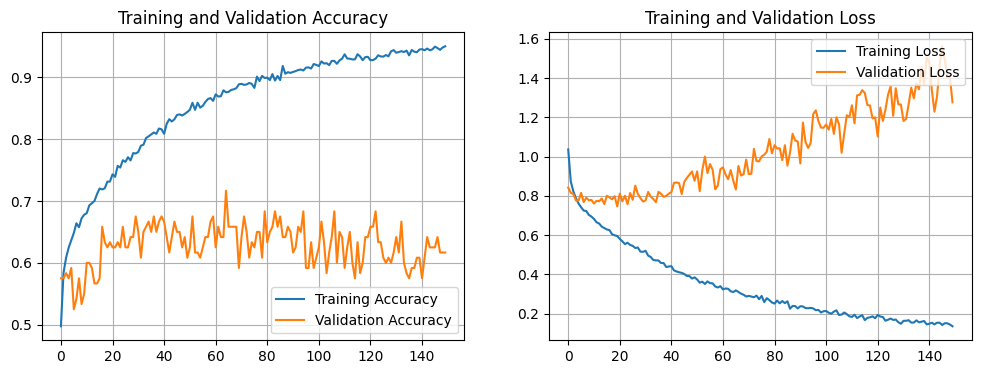

In [20]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    # --- CORRECCIÓN AQUÍ ---
    # 1. Guardar PRIMERO
    save_path = os.path.join(RUN_SAVE_DIR, "training_history.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight') # dpi=300 para alta calidad, bbox_inches corta bordes blancos extra
    print(f"Gráfica guardada en: {save_path}")
    
    # 2. Mostrar DESPUÉS
    plt.show()

    
plot_training_history(history)

In [13]:
import numpy as np
import time
import torch
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import logging # Necesario para el type hinting o manejo interno

def evaluate_model(model, test_loader, device, class_names, output_dir, logger):
    """
    Evalúa un modelo entrenado y genera reporte.
    Ahora recibe 'logger' como argumento para asegurar que escriba en tu archivo .log.
    """
    logger.info("\n" + "="*40)
    logger.info("--- INICIANDO EVALUACIÓN EN TEST SET ---")
    logger.info("="*40)

    # 1. Poner el modelo en modo de evaluación (Apaga Dropout/BatchNorm)
    model.eval()

    all_labels = []
    all_preds = []
    
    total_inference_time = 0.0
    total_samples = 0

    # 2. Iterar sobre el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # --- BLOQUE DE MEDICIÓN DE TIEMPO PRECISA ---
            # Si usas GPU, es obligatorio sincronizar antes y después del forward
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            start_time = time.time()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.time()
            # ---------------------------------------------
            
            # Acumular tiempo real de procesamiento
            total_inference_time += (end_time - start_time)
            total_samples += inputs.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Convertir a numpy
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # 3. Calcular Métricas
    logger.info("Calculando métricas estadísticas...")
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # zero_division=0 evita errores si una clase no tiene predicciones
    precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
    recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)
    f1_per_class = f1_score(true_labels, predicted_labels, average=None, zero_division=0)
    
    # Promedios Macro (trata todas las clases igual, útil si hay desbalance)
    avg_precision = np.mean(precision_per_class)
    avg_recall = np.mean(recall_per_class)
    avg_f1 = np.mean(f1_per_class)

    # Tiempo promedio por imagen (Métrica Clave para KAN vs VGG)
    avg_inference_time_ms = (total_inference_time / total_samples) * 1000 

    # 4. Matriz de Confusión Visual
    logger.info("Generando matriz de confusión...")
    cm = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d", # 'd' es para enteros (decimal), mejor que 'g' para conteos
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicción del Modelo", fontsize=12)
    plt.ylabel("Realidad (Ground Truth)", fontsize=12)
    plt.title(f"Matriz de Confusión - Accuracy: {accuracy:.2%}", fontsize=14)
    
    cm_path = os.path.join(output_dir, "confusion_matrix.png")
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close() # Cierra la figura para liberar memoria
    logger.info(f"Gráfico guardado en: {cm_path}")

    # 5. Reporte de Texto
    logger.info("Escribiendo reporte final...")
    
    metrics_df = pd.DataFrame({
        "Clase": class_names,
        "Precision": np.round(precision_per_class, 4),
        "Recall": np.round(recall_per_class, 4),
        "F1-Score": np.round(f1_per_class, 4),
    })

    report_path = os.path.join(output_dir, "test_metrics_report.txt")
    
    with open(report_path, "w", encoding='utf-8') as f:
        f.write("="*50 + "\n")
        f.write(f" REPORTE DE EVALUACIÓN: {time.strftime('%Y-%m-%d %H:%M')}\n")
        f.write("="*50 + "\n\n")
        
        f.write(f"Métricas Globales:\n")
        f.write(f"- Accuracy:          {accuracy:.4f} ({accuracy:.2%})\n")
        f.write(f"- Macro Precision:   {avg_precision:.4f}\n")
        f.write(f"- Macro Recall:      {avg_recall:.4f}\n")
        f.write(f"- Macro F1-Score:    {avg_f1:.4f}\n\n")
        
        f.write("-" * 30 + "\n")
        f.write("EFICIENCIA (Velocidad)\n")
        f.write("-" * 30 + "\n")
        f.write(f"- Muestras totales:  {total_samples}\n")
        f.write(f"- Tiempo total:      {total_inference_time:.4f} seg\n")
        f.write(f"- Tiempo por imagen: {avg_inference_time_ms:.4f} ms\n\n")
        
        f.write("-" * 30 + "\n")
        f.write("DETALLE POR CLASE\n")
        f.write("-" * 30 + "\n")
        # Usamos to_markdown si pandas es reciente, sino to_string
        try:
            f.write(metrics_df.to_markdown(index=False))
        except:
            f.write(metrics_df.to_string(index=False))
        
        f.write("\n\n")
        f.write("Matriz de Confusión (Texto):\n")
        f.write(np.array2string(cm, separator=', '))
        
    logger.info(f"Reporte de texto guardado en: {report_path}")
    logger.info("--- EVALUACIÓN FINALIZADA ---")
    
    return accuracy, avg_f1 # Retorna valores por si los necesitas en el script principal

In [14]:
test_dir = "data/test" # <--- Ruta a la carpeta de prueba
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [16]:
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, 'best_model.pth')
# 2. Crear una nueva instancia del modelo y cargar los mejores pesos
logger.info("Cargando el mejor modelo para la evaluación...")
eval_model = KAN_Model(num_classes=NUM_CLASSES).to(device)
eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
class_names = test_dataset.classes  # Obtener los nombres de las clases desde el dataset de prueba
class_names

2025-12-06 02:52:17,512 - INFO - Cargando el mejor modelo para la evaluación...


['Fresh_Leaf',
 'Leaf_Reddening',
 'Leaf_Spot_Bacterial_Blight',
 'Yellowish_Leaf']

In [17]:
# 3. Llamar a la función de evaluación
# Suponiendo que tienes un 'test_loader' y un 'RUN_DIR' definidos
evaluate_model(
    model=eval_model,
    
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    output_dir=RUN_SAVE_DIR, # El directorio de la ejecución actual para guardar los resultados
    logger=logger
)

2025-12-06 02:52:36,542 - INFO - 
2025-12-06 02:52:36,545 - INFO - --- INICIANDO EVALUACIÓN EN TEST SET ---
2025-12-06 02:52:36,548 - INFO - ========================================
2025-12-06 02:52:50,402 - INFO - Calculando métricas estadísticas...
2025-12-06 02:52:50,419 - INFO - Generando matriz de confusión...
2025-12-06 02:52:50,632 - INFO - Gráfico guardado en: models/sbtaylor_kan_cotton\run_20251205_204857\confusion_matrix.png
2025-12-06 02:52:50,633 - INFO - Escribiendo reporte final...
2025-12-06 02:52:50,653 - INFO - Reporte de texto guardado en: models/sbtaylor_kan_cotton\run_20251205_204857\test_metrics_report.txt
2025-12-06 02:52:50,655 - INFO - --- EVALUACIÓN FINALIZADA ---


(0.6166666666666667, np.float64(0.6135855524642289))